In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
# from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/home/risb/Desktop/BTP2/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [ ]:
CLASSES: dict[int, str] = {
    -1: "None",
    0: "Spam/Scam/Garbage",
    1: "Non-Complaint ",
    # -- Rest are complaints --
    2: "Delay",
    3: "Hygeine (food, toilets, carriage)",
    4: "Ticket issue (cancellation, refund, seat change)",
    5: "Medical issue",
    6: "Safety issue",
    7: "Travel Experience",
    8: "Feedback / Suggestions (less critical/urgent)",
}
URGENCY: dict[int, str] = {
    -1: "None",
    0: "Low",
    1: "Pressing",
    2: "critical",
}
LANG: dict[int, str] = {
    -1: "None",
    0: "English",
    1: "Hindi (devanagari; purely)",
    2: "Hinglish (devanagari; with english in latin alphabet)",
    3: "Hinglish (devanagari; with english transliterated to hindi)",
    4: "Hinglish (latin; with hindi transliterated to english)",
}

### Training the urgency detection model

In [3]:
df_urg = pd.read_csv('./eng_data_c_urg.csv')

print(df_urg['urgency'].value_counts())
print(len(df_urg))

urgency
0    713
1    650
2    136
Name: count, dtype: int64
1499


NaN (float) to empty string

In [4]:
for idx, i in enumerate(df_urg.loc[:, "SentimentText"]):
    if type(i) == float:
        df_urg.loc[idx, "SentimentText"] = ""

In [5]:
import time
train_texts_urg, val_texts_urg, train_labels_urg, val_labels_urg = train_test_split(
    df_urg['SentimentText'].tolist(), df_urg['urgency'].tolist(), test_size=0.2, random_state=(time.time_ns() % 943024), stratify=df_urg['urgency']
)

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings_urg = tokenizer(train_texts_urg, truncation=True, padding=True, max_length=128)
val_encodings_urg = tokenizer(val_texts_urg, truncation=True, padding=True, max_length=128)

In [7]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_urg = TweetDataset(train_encodings_urg, train_labels_urg)
val_dataset_urg = TweetDataset(val_encodings_urg, val_labels_urg)

train_loader_urg = DataLoader(train_dataset_urg, batch_size=32, shuffle=True)
val_loader_urg = DataLoader(val_dataset_urg, batch_size=32)

In [8]:
model_urg = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
# model_urg = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
model_urg.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
optimizer = AdamW(model_urg.parameters(), lr=5e-5)

num_epochs = 6
num_training_steps = num_epochs * len(train_loader_urg)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

model_urg.train()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    pbar = tqdm(train_loader_urg, desc="Training")
    for batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_urg(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        pbar.set_postfix(loss=loss.item())


Epoch 1/6


Training: 100%|██████████| 38/38 [00:30<00:00,  1.26it/s, loss=0.981]



Epoch 2/6


Training: 100%|██████████| 38/38 [00:30<00:00,  1.26it/s, loss=0.837]



Epoch 3/6


Training: 100%|██████████| 38/38 [00:30<00:00,  1.26it/s, loss=0.666]



Epoch 4/6


Training: 100%|██████████| 38/38 [00:30<00:00,  1.26it/s, loss=0.373]



Epoch 5/6


Training: 100%|██████████| 38/38 [00:30<00:00,  1.26it/s, loss=0.162] 



Epoch 6/6


Training: 100%|██████████| 38/38 [00:30<00:00,  1.24it/s, loss=0.0578]


In [ ]:
# %pip install -q seaborn matplotlib

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model_urg.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader_urg, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_urg(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

urg_labels = ["Low", "Pressing", "Critical"]
print("\n" + classification_report(all_labels, all_preds, target_names=urg_labels))

Evaluating: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


              precision    recall  f1-score   support

         Low       0.62      0.65      0.63       143
    Pressing       0.56      0.55      0.56       130
    Critical       0.29      0.22      0.25        27

    accuracy                           0.57       300
   macro avg       0.49      0.48      0.48       300
weighted avg       0.56      0.57      0.57       300



[[93 45  5]
 [48 72 10]
 [ 9 12  6]]


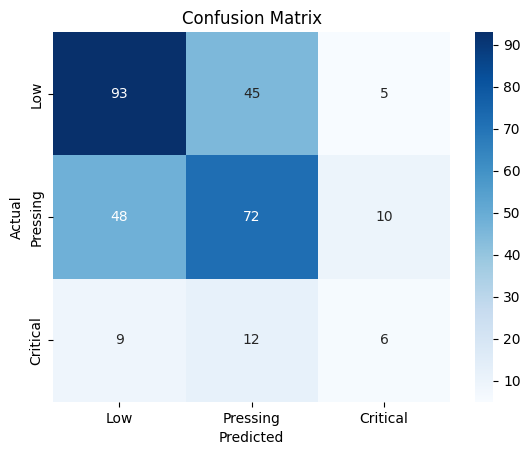

In [11]:
cm = confusion_matrix(all_labels, all_preds)
print(cm)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=urg_labels, yticklabels=urg_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
model_urg.save_pretrained("bert_urgency_classifier")
tokenizer.save_pretrained("bert_urgency_classifier")

('bert_urgency_classifier/tokenizer_config.json',
 'bert_urgency_classifier/special_tokens_map.json',
 'bert_urgency_classifier/vocab.txt',
 'bert_urgency_classifier/added_tokens.json')

In [13]:
import gc

In [14]:
try: model_urg.cpu()
except: pass

try: del model_urg
except: pass

try: del optimizer
except: pass

try: del lr_scheduler
except: pass

try:
    with torch.no_grad():
        torch.cuda.empty_cache()
except: pass

try: del torch
except: pass

try: del AdamW
except: pass

try: del tqdm
except: pass

try: del Dataset, DataLoader
except: pass


gc.collect()

5204